### This code visualizes the observation function, derived from CHIME injections (CHIME Collaboration et al. 2021, Merryfield et al. 2022). It was most kindly provided to us by Kiyoshi Masui, and is a data product of the CHIME Catalog 1 paper.

In [1]:
import numpy as np
from scipy.interpolate import griddata, SmoothBivariateSpline
from importlib_resources import files
import matplotlib.pyplot as plt

### Plot the observation function

C:\Users\Om\AppData\Local\Temp\ipykernel_17876\1637529898.py:11: RuntimeWarning: divide by zero encountered in log10
  of_det = np.log10(of_det[7:,:])


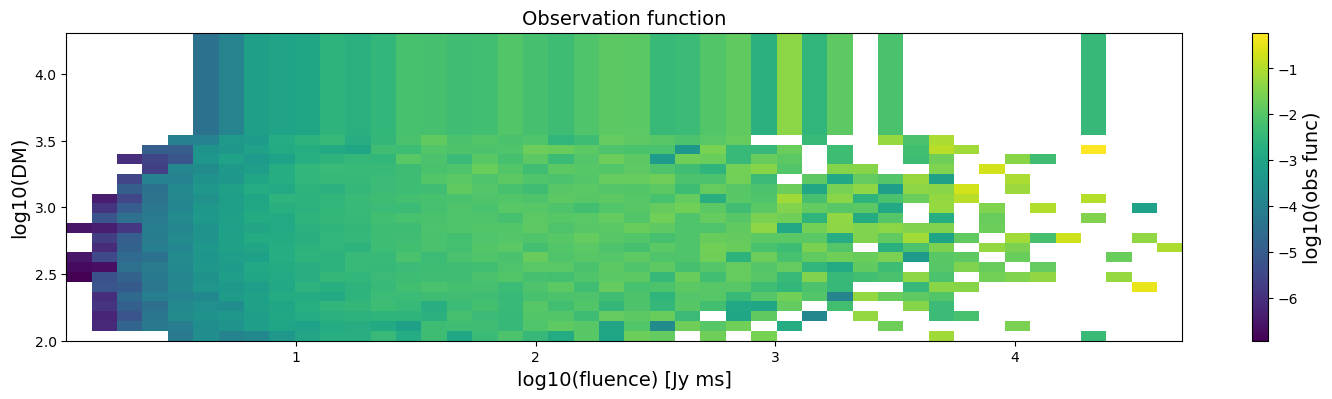

In [ ]:
# Import CHIME observation function file
# Courtesy: Kiyoshi Masui
obsfunc = np.load("files/observation_function.npz")
of_snr = obsfunc['snr_edges']
of_flu = obsfunc['flu_edges']
of_dm = obsfunc['dm_edges']
of = obsfunc['observation_function']
of_det = np.zeros((of_flu.shape[0]-1, of_dm.shape[0]-2))
for i in range(1,of_snr.shape[0]-1):
    of_det[:,:] += of[i,:,1:]*(of_snr[i+1] - of_snr[i])  
of_det = np.log10(of_det[7:,:])

fig, ax = plt.subplots(1,1, figsize=(18,4))

# Plot the value of the 2D grid as colors mapped onto the colormap
X, Y = np.meshgrid(np.log10(of_flu[7:]*1000), np.log10(of_dm[1:]))
cmesh0 = ax.pcolormesh(X, Y, of_det.T)
# Set the colorbar to show range of color values
cbar = fig.colorbar(cmesh0)
cbar.ax.set_ylabel('log10(obs func)', fontsize=14)

# Label x- and y-axes 
ax.set_xlabel("log10(fluence) [Jy ms]", fontsize=14)
ax.set_ylabel("log10(DM)", fontsize=14)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.title("Observation function", fontsize=14)
plt.show()

### Plot one of the DM rows

2.441162298385793


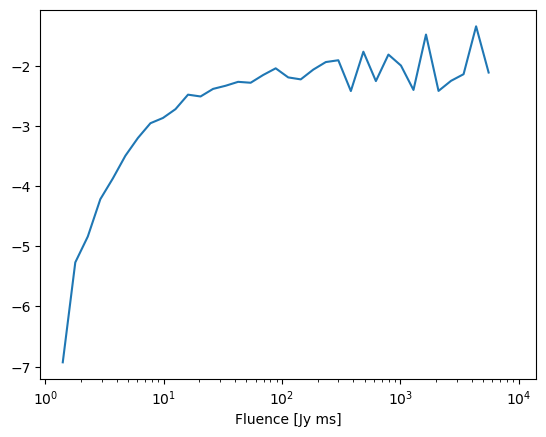

In [37]:
i = 7
print(np.log10(of_dm[i]))
plt.plot(of_flu[8:-7]*1000, of_det[:, i-1])
plt.xlabel('Fluence [Jy ms]')
plt.xscale('log')
plt.show()

### Limit the fluence range and interpolate the observation function

C:\Users\Om\AppData\Local\Temp\ipykernel_17876\960203617.py:9: RuntimeWarning: divide by zero encountered in log10
  of_det = np.log10(of_det[7:-7,:])


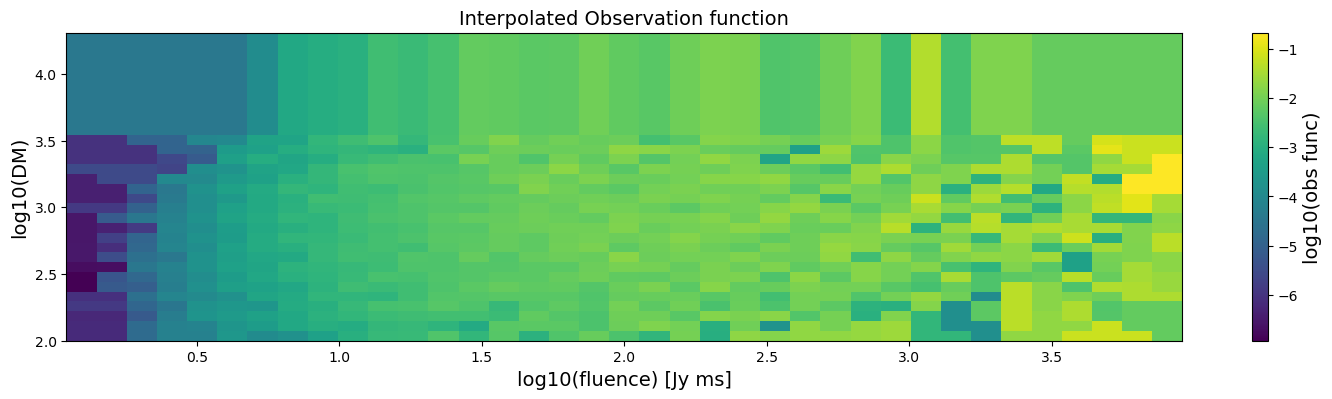

In [ ]:
obsfunc = np.load(files('files').joinpath('observation_function.npz'))
of_snr = obsfunc['snr_edges']
of_flu = obsfunc['flu_edges']
of_dm = obsfunc['dm_edges']
of = obsfunc['observation_function']
of_det = np.zeros((of_flu.shape[0]-1, of_dm.shape[0]-2))
for i in range(1,of_snr.shape[0]-1):
    of_det[:,:] += of[i,:,1:]*(of_snr[i+1] - of_snr[i])  
of_det = np.log10(of_det[7:-7,:])

# Define array for DM and F array binning
logF_of = (np.log10(of_flu[7:-8]) + np.log10(of_flu[8:-7]))/2 + 3
logdm_of = (np.log10(of_dm[1:-1]) + np.log10(of_dm[2:]))/2

# Interpolate the missing points
inter_det = np.ma.masked_invalid(of_det)
xx, yy = np.meshgrid(logF_of, logdm_of, indexing='ij')
F_mask = xx[~inter_det.mask]
dm_mask = yy[~inter_det.mask]
inter_det = inter_det[~inter_det.mask]

interp2d = griddata((F_mask, dm_mask), inter_det.T, (xx, yy), method='nearest')

fig, ax = plt.subplots(1,1, figsize=(18,4))

# Plot the value of the 2D grid as colors mapped onto the colormap
X, Y = np.meshgrid(np.log10(of_flu[7:-7]*1000), np.log10(of_dm[1:]))
cmesh0 = ax.pcolormesh(X, Y, interp2d.T)
# Set the colorbar to show range of color values
cbar = fig.colorbar(cmesh0)
cbar.ax.set_ylabel('log10(obs func)', fontsize=14)

# Label x- and y-axes 
ax.set_xlabel("log10(fluence) [Jy ms]", fontsize=14)
ax.set_ylabel("log10(DM)", fontsize=14)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.title("Interpolated Observation function", fontsize=14)
plt.show()

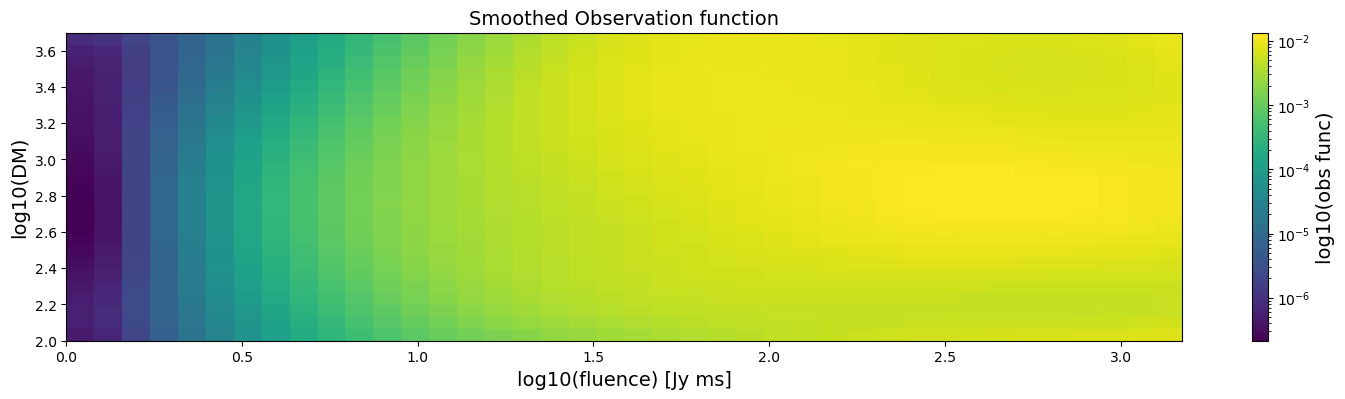

In [10]:
dz=0.01
x_param = [np.linspace(0,8,801), np.logspace(2.0,np.log10(5000),27), np.logspace(0,np.log10(1500),41)]
x_points = [np.arange(0.005,8.0,dz), 10**(np.log10(x_param[1][0:-1]) + np.diff(np.log10(x_param[1]))/2), 10**(np.log10(x_param[2][:-1]) + np.diff(np.log10(x_param[2]))/2)]

# Smooth over the full range of DM and F on a regularly spaced log-grid
inter_det = np.ma.masked_invalid(interp2d)
xx, yy = np.meshgrid(logF_of, logdm_of, indexing='ij')
F_mask = xx[~inter_det.mask]
dm_mask = yy[~inter_det.mask]
inter_det = inter_det[~inter_det.mask]

sbs = SmoothBivariateSpline(F_mask, dm_mask, inter_det, kx=5, ky=5)

xgrid, ygrid = np.meshgrid(np.log10(x_param[2]), np.log10(x_param[1]), indexing='ij')
logF = np.log10(x_param[2][:-1]) + np.diff(np.log10(x_param[2]))/2
logdm = np.log10(x_param[1][0:-1]) + np.diff(np.log10(x_param[1]))/2
xmidgrid, ymidgrid = np.meshgrid(logF, logdm, indexing='ij')

of_smooth = sbs(xmidgrid.ravel(), ymidgrid.ravel(), grid=False)

of_smooth = 10**of_smooth.reshape(logF.shape[0], logdm.shape[0])

fig, ax = plt.subplots(1,1, figsize=(18,4))

# Plot the value of the 2D grid as colors mapped onto the colormap
xgrid, ygrid = np.meshgrid(np.log10(x_param[2]), np.log10(x_param[1]), indexing='ij')
cmesh0 = ax.pcolormesh(xgrid, ygrid, of_smooth, norm='log')
# Set the colorbar to show range of color values
cbar = fig.colorbar(cmesh0)
cbar.ax.set_ylabel('log10(obs func)', fontsize=14)

# Label x- and y-axes 
ax.set_xlabel("log10(fluence) [Jy ms]", fontsize=14)
ax.set_ylabel("log10(DM)", fontsize=14)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.title("Smoothed Observation function", fontsize=14)
plt.show()

### Plot the smoothed observation function for one of the DM rows

265.9147948472494


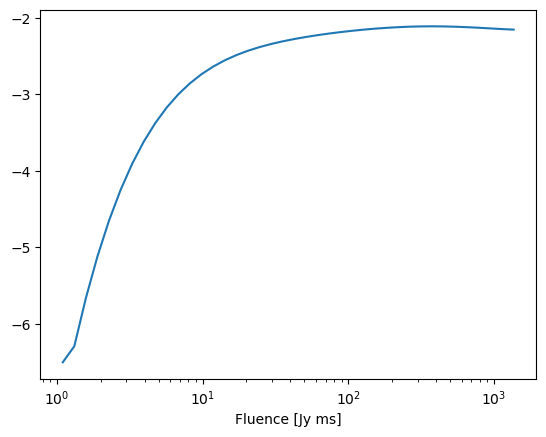

In [44]:
i = 6
print(x_points[1][i])
plt.plot(x_points[2], np.log10(of_smooth[:, i].T))
plt.xlabel('Fluence [Jy ms]')
plt.xscale('log')
plt.show()